In [273]:
import numpy as np
import heartpy as hp
import sensormotion as sm
import pandas as pd

from scipy.signal import butter,filtfilt,find_peaks
from scipy import stats
from itertools import product
import glob

import matplotlib.pyplot as plt
import plotly_express as px

## Read files / Adjust Timestamps

In [241]:
bvp_file_list = glob.glob("Performance3/*_bvp.csv")
eda_file_list = glob.glob("Performance3/*_eda.csv")
acc_file_list = glob.glob("Performance3/*_acc.csv")

In [242]:
df_bvp = dict()
for file in bvp_file_list:
    df_bvp[file[13:16]] = pd.read_csv(file).query('signalOK == 1')
    
df_eda =dict()
for file in eda_file_list:
    df_eda[file[13:16]] = pd.read_csv(file)
    
df_acc =dict()
for file in acc_file_list:
    df_acc[file[13:16]] = pd.read_csv(file)

In [243]:
sublist = ['301','302','303', '304','305','306', '309', '312','313', '314', '317','319', '321', '322', '325', '326','327','328','329','330',
 '331', '334','335','340','341','342']

In [244]:
def set_timepass(data, start):
    data['timepass'] = data['localTime'] - start
    data['timepassSec'] = round(data['timepass']/1000, ndigits= 0)
    data['timepassMin'] = round(data['timepassSec']/60, ndigits= 0)
    data = data.query('20< timepassMin< 95').reset_index()    # performance time duration 
    return data

In [245]:
concated_list = []
for key in df_bvp.keys():
    concated_list.append(df_bvp[key])
df_all = pd.concat(concated_list,axis=0)    
earliestTime = df_all['localTime'].min()

for key in sublist:
    df_bvp[key] = set_timepass(df_bvp[key], earliestTime)
    df_eda[key] = set_timepass(df_eda[key], earliestTime)
    df_acc[key] = set_timepass(df_acc[key],earliestTime)
    

## Clean/Filter

In [246]:
# calculate the root sum of squared three dimensional acc values
rss_std = dict()

for key in sublist:
    b, a = sm.signal.build_filter(frequency=2, sample_rate=50, filter_type='low', filter_order=4)

    df_acc[key]['accX_filtered'] = sm.signal.filter_signal(b, a, signal=df_acc[key]['accX'])
    df_acc[key]['accY_filtered'] = sm.signal.filter_signal(b, a, signal=df_acc[key]['accY'])
    df_acc[key]['accZ_filtered'] = sm.signal.filter_signal(b, a, signal=df_acc[key]['accZ'])
    
    df_acc[key]['rss'] = np.sqrt(df_acc[key]['accX_filtered']**2+df_acc[key]['accY_filtered']**2+df_acc[key]['accZ_filtered']**2)
    rss_std[key] = df_acc[key]['rss'].std()
    
    df_acc[key]['rss_peaks_max'] = df_acc[key].iloc[ find_peaks(df_acc[key]['rss'], distance =25 ,prominence=rss_std[key]*1.5)[0]]['rss']
    df_acc[key]['rss_peaks_min'] = df_acc[key].iloc[ find_peaks(df_acc[key]['rss']*-1, distance =25 ,prominence=rss_std[key]*1.5)[0]]['rss']

In [247]:
#bvp low pass filter
freq = 50
fc = 3.5 # Cut-off frequency of the filter
w = fc / (freq / 2) # Normalize the frequency
b, a = butter(2, w, 'low')

for key in sublist:

    df_bvp[key] = pd.merge(df_bvp[key],df_acc[key],on=['remoteTime','timepass','timepassSec','timepassMin'],how = 'inner')
    df_bvp[key]['peaks_combined'] = df_bvp[key]['rss_peaks_max'].astype(str) + df_bvp[key]['rss_peaks_min'].astype(str)
    droplist = df_bvp[key][df_bvp[key]['peaks_combined'] !='nannan']['timepassSec'].unique().tolist()
    df_bvp[key].drop(df_bvp[key][df_bvp[key]['timepassSec'].isin(droplist)].index,inplace = True)
    
    df_bvp[key]['bvp_filtered'] = filtfilt(b, a, df_bvp[key]['bvp'])
    df_bvp[key] = df_bvp[key].loc[:,['remoteTime','timepass','timepassSec','timepassMin','bvp','bvp_filtered']]  


## Explore/Plot

In [248]:
def plot_peak_signal( start, end, data, time, signal1, signal2,marker1):
    
    plt.figure(figsize=(20,5))
    plt.scatter(data[start:end][time], data[start:end][signal2], c='orange', s =10)
    plt.scatter(data[start:end][time], data[start:end][signal1], c='blue', s =10)
    plt.plot(data[start:end][time], data[start:end][signal2], c='grey')

    plt.plot(data[start:end][time], data[start:end][marker1], 'o', c='green')

    plt.show()

### Detect RR-intervals

In [249]:
peaks = dict()  # bvp peaks
rr = dict()  # inter-beat-interval (RR interval)
bpm = dict() # beats per minute 


for key in sublist:

    w,m = hp.process(df_bvp[key]['bvp_filtered'].to_numpy(),50, clean_rr=True)  
    peaks[key] = w['peaklist']
    
    rr[key] = w['RR_list']
    
    bpm[key] = m['bpm']
    
    p = np.array(peaks[key])
    df_bvp[key]['peaks'] = df_bvp[key].iloc[p]['bvp_filtered']

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:253: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



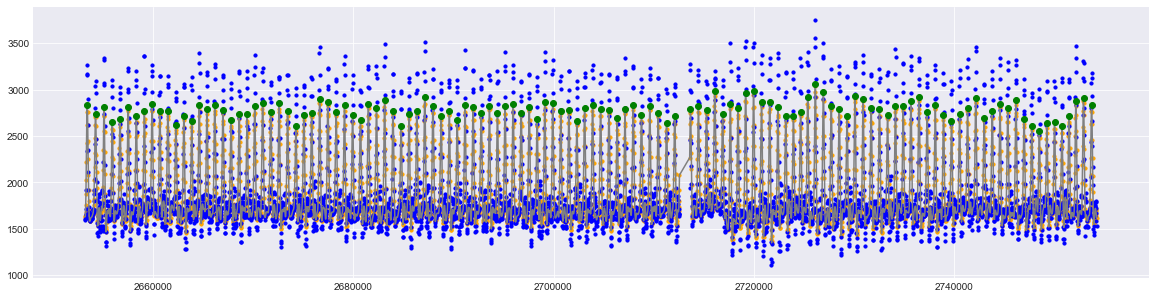

In [250]:
plot_peak_signal(20000,25000, df_bvp['328'],'remoteTime', 'bvp','bvp_filtered','peaks' )

### Sliding Window

In [251]:
WINDOW = 240  
INTERVAL = 240 * 0.5

df_sliced = dict()
for key in sublist:
    i = 1440
    df_sliced[key] = []
    while True:
        mask = (df_bvp[key]['timepassSec']>= i )& (df_bvp[key]['timepassSec'] < i + WINDOW)
        df_sliced[key].append(df_bvp[key][['remoteTime','timepass','timepassSec','timepassMin', 'bvp','bvp_filtered']][mask])
        i = i + INTERVAL
        if i >5600:
            break

In [252]:
rr_intervals_window = dict()
for key in sublist:
    value = df_sliced[key]
    rr_intervals_window[key] =[]
    for i in range (len(value)):
        w,m = hp.process(value[i]['bvp_filtered'].to_numpy(), 50, clean_rr= True)
        rr_intervals_window[key].append(w['RR_list'])
        

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:253: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:5244: RuntimeWarning:

Mean of empty slice.

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning:

Degrees of freedom <= 0 for slice



### Generate RR list

In [253]:
from hrvanalysis import remove_outliers, remove_ectopic_beats,  interpolate_nan_values
from boltons.iterutils import remap

In [254]:
#remove outliers
rr_intervals_without_outliers = dict()
for key in sublist:
    value = rr_intervals_window[key]
    rr_intervals_without_outliers[key] = []
    for i in range(len(value)):
        rr_intervals_without_outliers[key].append(remove_outliers(rr_intervals = value[i], low_rri =200, high_rri =1500))
    
    drop_falsey = lambda path, key, value: bool(value)
    rr_intervals_without_outliers[key] = remap(rr_intervals_without_outliers[key], visit=drop_falsey) 
    

0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1640.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1640.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 1680.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 1680.0]
0 outlier(s) have been deleted.
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [1620.0, 100.0]
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [1620.0, 120.0, 100.0, 1580.0]
3 outlier(s) have been deleted.
The outlier(s) value(s) are : [1580.0, 1700.0, 1580.0]
4 outlier(s) have been delet

12 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 1620.0, 80.0, 140.0, 3320.0, 120.0, 1600.0, 80.0, 1620.0, 100.0, 160.0, 140.0]
12 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 1600.0, 80.0, 1620.0, 100.0, 160.0, 120.0, 100.0, 120.0, 100.0, 3360.0, 140.0]
8 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 100.0, 120.0, 100.0, 3360.0, 140.0, 120.0, 80.0]
6 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 140.0, 100.0, 100.0, 80.0, 100.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0]
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 80.0, 100.0, 100.0]
5 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 100.0, 120.0, 40.0]
11 outlier(s) have been deleted.
The outlier(s) value(s) are : [20.0, 120.0, 40.0, 80.0, 100.0, 80.0, 100.0, 100.0, 80.0, 80.0, 100.0]
11 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0, 100.0, 8

4 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 140.0, 180.0, 140.0]
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [140.0, 180.0, 140.0, 120.0]
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [140.0, 120.0, 140.0, 140.0]
22 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 1800.0, 120.0, 120.0, 1700.0, 120.0, 120.0, 120.0, 120.0, 120.0, 2040.0, 100.0, 120.0, 1660.0, 120.0, 100.0, 1820.0, 120.0, 100.0, 120.0, 120.0, 120.0]
25 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 120.0, 120.0, 2040.0, 100.0, 120.0, 1660.0, 120.0, 100.0, 1820.0, 120.0, 100.0, 120.0, 120.0, 120.0, 100.0, 100.0, 100.0, 2000.0, 1800.0, 120.0, 140.0, 120.0, 3020.0, 120.0]
12 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 100.0, 2000.0, 1800.0, 120.0, 140.0, 120.0, 3020.0, 120.0, 120.0, 120.0]
19 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 120.0, 100.0, 1720.0, 120.0, 120.0, 1

2 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 80.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0, 100.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 1580.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1580.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0, 1540.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0, 1540.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [60.0, 1580.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 1580.0]
6 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 140.0, 120.0, 140.0, 120.0, 140.0]
6 outlier(s) have been deleted.
The outlier(s) value(s) are : [140.0, 120.0, 140.0, 140.0, 140.0, 140.0]
8 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 140.0, 140.0, 120.0, 120.0, 140.0, 1780.

1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1820.0]
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0, 100.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1620.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1540.0]
3 outlier(s) have been deleted.
The outlier(s) value(s) are : [1540.0, 1940.0, 1960.0]
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 120.0, 120.0]
5 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 100.0, 100.0, 100.0, 120.0]
5 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 100.0, 120.0, 100.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0]
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [

0 outlier(s) have been deleted.
0 outlier(s) have been deleted.
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [80.0]
0 outlier(s) have been deleted.
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0]
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [60.0]
0 outlier(s) have been deleted.
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0]
3 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 80.0]
8 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 80.0, 180.0, 120.0, 120.0, 120.0, 80.0]
12 outlier(s) have been deleted.
The outlier(s) value(s) are : [180.0, 120.0, 120.0, 120.0, 80.0, 40.0, 120.0, 1620.0, 120.0, 140.0, 140.0, 100.0]
11 outlier(s) have been deleted.
The outlier(s) value(s) are : [40.0, 120.0, 1620.0, 120.0, 140.0, 140.0, 100.0, 100.0, 120.0, 120.0, 120.0]
6 outlier(s) have been deleted.
The o

14 outlier(s) have been deleted.
The outlier(s) value(s) are : [120.0, 100.0, 80.0, 2000.0, 100.0, 120.0, 120.0, 100.0, 100.0, 100.0, 1680.0, 100.0, 100.0, 100.0]
21 outlier(s) have been deleted.
The outlier(s) value(s) are : [2000.0, 100.0, 120.0, 120.0, 100.0, 100.0, 100.0, 1680.0, 100.0, 100.0, 100.0, 1520.0, 100.0, 1720.0, 60.0, 120.0, 120.0, 120.0, 120.0, 100.0, 1620.0]
17 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 1720.0, 60.0, 120.0, 120.0, 120.0, 120.0, 100.0, 1620.0, 120.0, 120.0, 120.0, 1540.0, 120.0, 120.0, 120.0, 120.0]
13 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 1660.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 80.0, 1640.0, 2040.0, 80.0, 100.0]
15 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 100.0, 100.0, 1540.0, 80.0, 80.0, 1960.0, 100.0, 100.0, 120.0, 1580.0, 120.0, 100.0, 100.0]
9 outlier(s) have been deleted.
The outlier(s) value(s) are : [100.0, 100.0, 100.0, 1780.0, 20.0, 100.0, 60.0, 

In [255]:
# remove ectopic beats
nn_list_window = dict()
for key in sublist:
    value = rr_intervals_without_outliers [key]
    nn_list_window[key] =[]

    for i in range(len(value)):
        nn = remove_ectopic_beats(rr_intervals = value[i], method = "malik")
        nn_array = np.asarray(nn)
        
        result = nn_array[np.logical_not(np.isnan(nn_array))]
        nn_list_window[key].append(result.tolist())

7 ectopic beat(s) have been deleted with malik rule.
4 ectopic beat(s) have been deleted with malik rule.
4 ectopic beat(s) have been deleted with malik rule.
1 ectopic beat(s) have been deleted with malik rule.
5 ectopic beat(s) have been deleted with malik rule.
6 ectopic beat(s) have been deleted with malik rule.
4 ectopic beat(s) have been deleted with malik rule.
3 ectopic beat(s) have been deleted with malik rule.
0 ectopic beat(s) have been deleted with malik rule.
0 ectopic beat(s) have been deleted with malik rule.
0 ectopic beat(s) have been deleted with malik rule.
4 ectopic beat(s) have been deleted with malik rule.
9 ectopic beat(s) have been deleted with malik rule.
15 ectopic beat(s) have been deleted with malik rule.
26 ectopic beat(s) have been deleted with malik rule.
30 ectopic beat(s) have been deleted with malik rule.
20 ectopic beat(s) have been deleted with malik rule.
17 ectopic beat(s) have been deleted with malik rule.
24 ectopic beat(s) have been deleted with

14 ectopic beat(s) have been deleted with malik rule.
12 ectopic beat(s) have been deleted with malik rule.
20 ectopic beat(s) have been deleted with malik rule.
18 ectopic beat(s) have been deleted with malik rule.
17 ectopic beat(s) have been deleted with malik rule.
9 ectopic beat(s) have been deleted with malik rule.
10 ectopic beat(s) have been deleted with malik rule.
27 ectopic beat(s) have been deleted with malik rule.
36 ectopic beat(s) have been deleted with malik rule.
28 ectopic beat(s) have been deleted with malik rule.
20 ectopic beat(s) have been deleted with malik rule.
20 ectopic beat(s) have been deleted with malik rule.
22 ectopic beat(s) have been deleted with malik rule.
18 ectopic beat(s) have been deleted with malik rule.
16 ectopic beat(s) have been deleted with malik rule.
21 ectopic beat(s) have been deleted with malik rule.
15 ectopic beat(s) have been deleted with malik rule.
18 ectopic beat(s) have been deleted with malik rule.
20 ectopic beat(s) have been 

7 ectopic beat(s) have been deleted with malik rule.
5 ectopic beat(s) have been deleted with malik rule.
3 ectopic beat(s) have been deleted with malik rule.
6 ectopic beat(s) have been deleted with malik rule.
11 ectopic beat(s) have been deleted with malik rule.
16 ectopic beat(s) have been deleted with malik rule.
16 ectopic beat(s) have been deleted with malik rule.
9 ectopic beat(s) have been deleted with malik rule.
4 ectopic beat(s) have been deleted with malik rule.
2 ectopic beat(s) have been deleted with malik rule.
5 ectopic beat(s) have been deleted with malik rule.
16 ectopic beat(s) have been deleted with malik rule.
21 ectopic beat(s) have been deleted with malik rule.
14 ectopic beat(s) have been deleted with malik rule.
11 ectopic beat(s) have been deleted with malik rule.
7 ectopic beat(s) have been deleted with malik rule.
7 ectopic beat(s) have been deleted with malik rule.
15 ectopic beat(s) have been deleted with malik rule.
21 ectopic beat(s) have been deleted w

### Generate HRV features

In [258]:
from hrvanalysis import get_time_domain_features, get_frequency_domain_features

In [259]:
timedomain_features = dict()
frequencydomain_features = dict()
for key in sublist:
    print(key)
    value = nn_list_window[key]
    timedomain_features[key] = []
    frequencydomain_features[key] = []
    for i in range(len(value)):
         if len(value[i])>2:
            timedomain_features[key].append(get_time_domain_features(value[i]))
            frequencydomain_features[key].append(get_frequency_domain_features(value[i]))

301
302
303


/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 159, using nperseg = 159

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 128, using nperseg = 128



304
305
306
309
312


/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 252, using nperseg = 252

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 208, using nperseg = 208

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 147, using nperseg = 147

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 164, using nperseg = 164

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 203, using nperseg = 203

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input leng

313
314
317
319


/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 98, using nperseg = 98

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 238, using nperseg = 238

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 119, using nperseg = 119



321
322
325
326
327
328
329


/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 177, using nperseg = 177

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 246, using nperseg = 246

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 92, using nperseg = 92

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 69, using nperseg = 69

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 193, using nperseg = 193



330
331
334


/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 46, using nperseg = 46

/Users/hanjiawen/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning:

nperseg = 256 is greater than input length  = 117, using nperseg = 117



335
340
341
342


### Plot HRV features

In [260]:
def data_to_plot (subject,domain, feature):
    data = []
    featurevalue = domain[subject]
    for i in range(len(domain[subject])):
        data.append(df_sliced[subject][i].iloc[0].to_frame().T)
        data[i][feature] = featurevalue[i][feature]
    
    dataframe= pd.concat(data)
    dataframe['time'] = dataframe['timepassMin'] -24
    dataframe['time']= dataframe['time'].apply(lambda x:  x if x % 2 == 0 else (x-1))

    return dataframe

In [329]:
def plot_hrv_feature(subject,domain,feature):
    df = data_to_plot(subject,domain,feature)
    fig = px.line(df, x="time", y=feature, title=subject+'_'+feature,width=800, height=350,template='simple_white')
    fig.update_traces(mode='markers+lines')
    fig.show()

In [330]:
plot_hrv_feature('319',timedomain_features,'pnni_50')
# change [ subject_number, hrv_domain_type ('timedomain_features'/'frequencydomain_features', feature name ]to plot

In [327]:
def plot_hrv_all(domain,feature):
    concated_list = []
    for subject in sublist:
        dataframe = data_to_plot(subject,domain,feature)
        dataframe['normalized_' +feature] = dataframe[feature]/(60000/bpm[subject])
        # normalized each subject's hrv feature value 
        concated_list.append(dataframe)
        
    dataframe_all = pd.concat(concated_list, axis=0)
    df = dataframe_all.groupby('time')['normalized_'+feature].mean().reset_index()
    fig = px.line(df, x="time", y='normalized_'+feature, title= feature,width=800, height=350, template='simple_white')
    fig.update_traces(mode='markers+lines')
    fig.show()
    

In [328]:
plot_hrv_all(timedomain_features, 'pnni_50')
# change [ hrv_domain_type ('timedomain_features'/'frequencydomain_features', feature name ]to plot all subjects' average value